In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from PixelCNN.model import PixelCNN
from Diffusion.diffusion_model import DiffusionModel
from Diffusion.variance import VarianceSchedule
from Diffusion.time_embedding import TimeEmbedding
import pathlib
from UNet.config import Config
from Dataset.random_crop import RandomPaddedCrop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from importlib import reload
from training import train_step, test_step

In [5]:
import Diffusion.diffusion_model
reload(Diffusion.diffusion_model)

import Diffusion.time_embedding
reload(Diffusion.time_embedding)

import Dataset.random_crop
reload(Dataset.random_crop)

import UNet.config
reload(UNet.config)

import Diffusion.variance
reload(Diffusion.variance)

import training
reload(training)

<module 'training' from '/content/training.py'>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_dir = pathlib.Path("/content/drive/MyDrive") / "Cars Dataset"
train_dir = data_dir / "train"
test_dir = data_dir / "test"

cfg = Config()

In [13]:
img_transform = transforms.Compose([
    RandomPaddedCrop((256, 256)),
    transforms.TrivialAugmentWide(),
    transforms.Resize((cfg.im_size, cfg.im_size)),
    transforms.ToTensor(),
])

In [14]:
test_dataset = datasets.ImageFolder(
    test_dir, transform=img_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
)

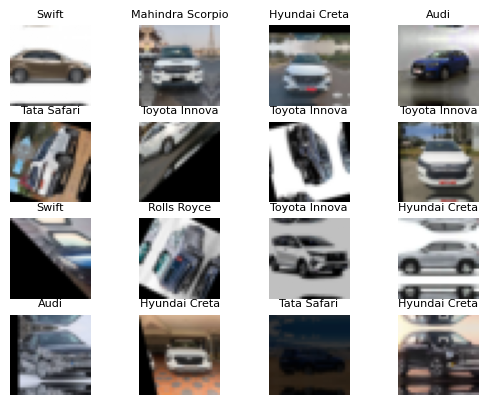

In [15]:
img, label = next(iter(test_loader ))
img = img[:16]


for i in range(img.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i].permute(1, 2, 0))
    plt.title(f"{test_dataset.classes[label[i]]}", fontsize=8)
    plt.axis('off')
plt.show()

In [ ]:
time_embedding = TimeEmbedding(cfg.time_embedding_dim, cfg.embedding_dim, cfg.num_timesteps)

label_embedding = torch.nn.Embedding(len(test_dataset.classes), cfg.embedding_dim)

In [16]:
diff_model = DiffusionModel()

loss = nn.MSELoss()
optimizer = optim.Adam(diff_model.parameters(), lr=cfg.lr)

In [18]:
import tqdm

train_losses, test_losses, batches = [], [], []
N_SAMPLES = 4

batches_processed = 0

Epoch 1/10 - Train Loss: 0.7300 - Test Loss: 0.7307: 100%|██████████| 26/26 [02:26<00:00,  5.62s/it]


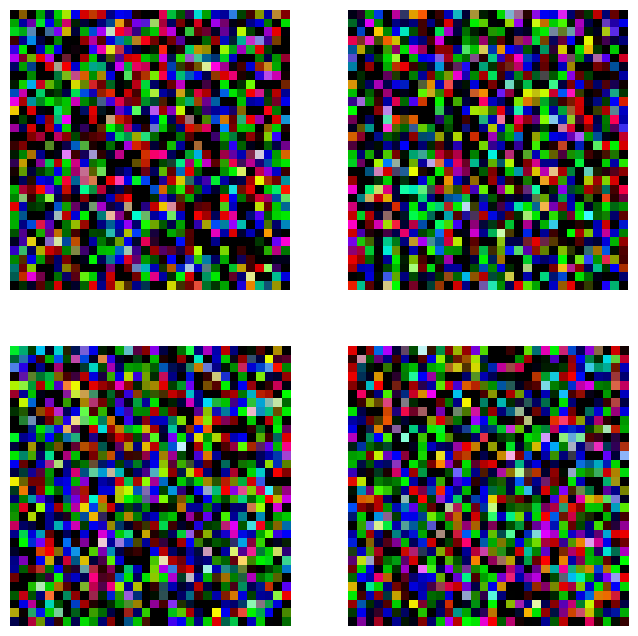

Epoch 2/10 - Train Loss: 0.7319 - Test Loss: 0.7124:  15%|█▌        | 4/26 [00:23<02:10,  5.94s/it]

In [ ]:


for epoch in range(cfg.epochs):
    tq = tqdm.tqdm(test_loader)
    for batch_idx, (data, target) in enumerate(tq):
        train_loss = train_step(
            diff_model, (data, target), optimizer, loss, cfg.device
        )

        train_losses.append(train_loss)
        batches_processed += 1
        batches.append(batches_processed)


        test_batch = next(iter(test_loader))
        test_loss = test_step(
            diff_model, test_batch, loss, cfg.device
        )

        test_losses.append(test_loss)
        tq.set_description(f"Epoch {epoch + 1}/{cfg.epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")
        tq.refresh()

    gen_images, labels = diff_model.generate_images(N_SAMPLES)
    plt.figure(figsize=(8, 8))
    for i in range(N_SAMPLES):
        plt.subplot(2, 2, i + 1)
        plt.imshow(gen_images[i].transpose(1, 2, 0))
        plt.axis('off')
    plt.show()
    plt.close()

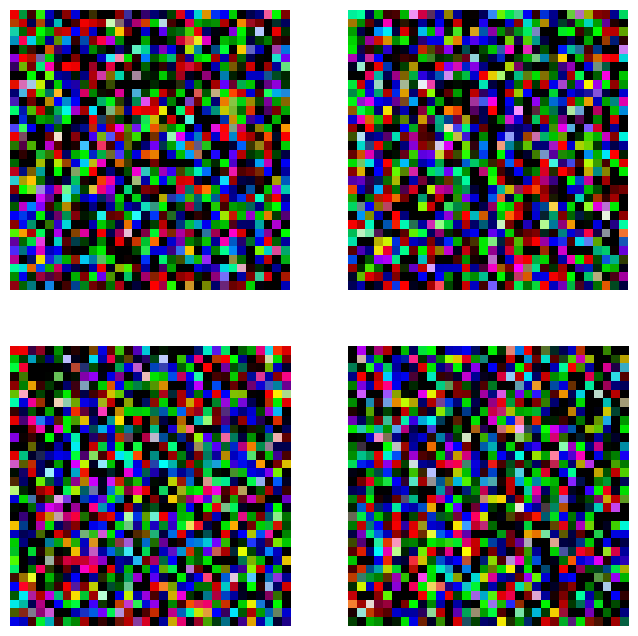

In [22]:
# gen_images, labels = diff_model.generate_images(N_SAMPLES, use_tqdm=True)
plt.figure(figsize=(8, 8))
for i in range(N_SAMPLES):
    plt.subplot(2, 2, i + 1)
    plt.imshow(gen_images[i].transpose(1, 2, 0))
    plt.axis('off')
plt.show()
plt.close()